# Description

This solution is based on GCANet(https://github.com/cddlyf/GCANet). The net was trained for a long time with weight decay. Protocol of the training are presented above. Final weights also presented 

# Some constants and gdrive mount

In [5]:
import torch
workDir='/home/data/'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


%cd '/home'
!mkdir 'data'
%cd '/home/data'

Mounted at /content/drive
/home
mkdir: cannot create directory ‘data’: File exists
/home/data


# Data loading

In [7]:
!pip install -U aicrowd-cli

     |████████████████████████████████| 61kB 4.5MB/s 
     |████████████████████████████████| 81kB 5.4MB/s 
     |████████████████████████████████| 204kB 11.5MB/s 
     |████████████████████████████████| 92kB 6.4MB/s 
     |████████████████████████████████| 61kB 6.4MB/s 
     |████████████████████████████████| 174kB 12.8MB/s 
     |████████████████████████████████| 61kB 4.1MB/s 
     |████████████████████████████████| 51kB 5.2MB/s 
     |████████████████████████████████| 71kB 7.3MB/s 
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1
  Found existing installation: click 8.0.0
    Uninstalling click-8.0.0:
      Successfully uninstalled click-8.0.0
  Found existing installation: requests 2.23.0
    Uni

In [9]:
API_KEY = '52ab6eb031245b7028158e2f3e993174' #Please enter your API Key from [https://www.aicrowd.com/participants/me]
!aicrowd login --api-key $API_KEY

API Key valid
Saved API Key successfully!


In [10]:
!aicrowd dataset download --challenge f1-smoke-elimination -j 3

sample_submission.zip:   0% 0.00/38.8M [00:00<?, ?B/s]
sample_submission.zip: 100% 38.8M/38.8M [00:00<00:00, 59.3MB/s]
test.zip:   0% 0.00/38.6M [00:00<?, ?B/s]
train.zip:  10% 33.6M/328M [00:02<00:18, 15.9MB/s]

val.zip:   0% 0.00/32.8M [00:00<?, ?B/s]
train.zip:  20% 67.1M/328M [00:03<00:14, 17.5MB/s]

val.zip: 100% 32.8M/32.8M [00:03<00:00, 10.5MB/s]
test.zip: 100% 38.6M/38.6M [00:04<00:00, 8.80MB/s]

train.zip:  31% 101M/328M [00:05<00:12, 18.1MB/s] 
train.zip:  41% 134M/328M [00:07<00:10, 18.6MB/s]
train.zip:  51% 168M/328M [00:09<00:08, 17.8MB/s]
train.zip:  61% 201M/328M [00:11<00:06, 18.7MB/s]
train.zip:  72% 235M/328M [00:12<00:04, 19.0MB/s]
train.zip:  82% 268M/328M [00:14<00:03, 17.9MB/s]
train.zip:  92% 302M/328M [00:16<00:01, 18.0MB/s]
train.zip: 100% 328M/328M [00:17<00:00, 18.6MB/s]


In [11]:
!rm -rf data
!mkdir data

!unzip -q train.zip  -d data/train
!unzip -q val.zip -d data/val
!unzip -q test.zip  -d data/test

!mv train.csv data/train.csv
!mv val.csv data/val.csv
!mv sample_submission.csv data/sample_submission.csv

mv: cannot stat 'train.csv': No such file or directory
mv: cannot stat 'val.csv': No such file or directory
mv: cannot stat 'sample_submission.csv': No such file or directory


# Custom dataset class and dataloaders

In [12]:
import torch
from torch.utils.data import Dataset,DataLoader,RandomSampler
from torchvision import transforms as T
import pandas as pd
import numpy as np
from PIL import Image

class ImageDataset(Dataset):
  def __init__(self,ImageFold,dsLen):
    self.ImageFold=ImageFold
    self.dsLen=dsLen

  def __len__(self):
    return self.dsLen

  def __getitem__(self,ind):
    im_smoke=self.load_image(ind,'smoke/')
    im_clear=self.load_image(ind,'clear/')
    

    im_smoke = (np.asarray(im_smoke)/255)
    im_clear = (np.asarray(im_clear)/255)
    im_smoke = torch.from_numpy(im_smoke).float()
    im_clear = torch.from_numpy(im_clear).float()
    return im_smoke.permute(2,0,1), im_clear.permute(2,0,1)

  def load_image(self,ind,t):
    return Image.open(self.ImageFold+t+str(ind)+'.jpg')

In [13]:

ds_train=ImageDataset(workDir+'data/train/',20000)
dl_train=DataLoader(ds_train,batch_size=16,shuffle=True,num_workers=2)

ds_val=ImageDataset(workDir+'data/val/',2000)
dl_val=DataLoader(ds_val,batch_size=16,shuffle=True,num_workers=2)

# Net object creation

In [14]:
!git clone https://github.com/cddlyf/GCANet
from GCANet import GCANet
net=GCANet.GCANet(3)
#net.load_state_dict(torch.load('/content/drive/MyDrive/state_dict_model_2.pt'))

fatal: destination path 'GCANet' already exists and is not an empty directory.


<All keys matched successfully>

# Fuction for drawing images

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
def show_image(hazy_image, gt_image, predicted_image):
    
    title = ['Ground Truth Image','Hazy Image', 'Predicted']
    
    plt.figure(figsize=(15, 15))
    
    
    display_list = [
                        hazy_image.cpu().permute(1, 2, 0).numpy(),
                        gt_image.cpu().permute(1, 2, 0).numpy(),
                        predicted_image.detach().cpu().permute(1, 2, 0).numpy()
                   ]
    
    
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
        
    plt.show()

# Training loop

In [16]:
import torch
import torch.nn as nn
import torchvision
import torch.backends.cudnn as cudnn
import torch.optim
import os
import sys
import argparse
import time
#import dataloader
import numpy as np
from torchvision import transforms
import torch.nn.functional as F


def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)


def train(dehaze_net,lr,n_epoch):



  criterion = nn.MSELoss().to(device)
#  lr=0.001
  optimizer = torch.optim.Adam(dehaze_net.parameters(), lr=lr)
	
  dehaze_net.train()

  for epoch in range(n_epoch):
    print('Epoch :' +str(epoch))


    epoch_loss=0
    for iteration, (img_haze,img_orig) in enumerate(dl_train):

      img_orig = img_orig.to(device)
      img_haze = img_haze.to(device)
      clean_image = dehaze_net(img_haze)
      loss = criterion(clean_image, img_orig)

      optimizer.zero_grad()
      loss.backward()
 #     torch.nn.utils.clip_grad_norm(dehaze_net.parameters(),0.01)
      optimizer.step()

      epoch_loss+= loss.detach().cpu().numpy()*len(img_orig)
      if ((iteration+1) % 10) == 0:
        print("Loss at iteration", iteration+1, ":", loss.item())

      if iteration % 200 == 0:
        torch.save(dehaze_net.state_dict(), '/content/drive/MyDrive/state_dict_model_checkpoint.pt')
        show_image(img_orig[0], img_haze[0], clean_image[0])

      if iteration % 600 == 0:
        lr=lr
        #/2
        optimizer = torch.optim.Adam(dehaze_net.parameters(), lr=lr)

    print('Epoch train loss: '+str(epoch_loss/len(dl_train.dataset)))
    epoch_loss=0

    with torch.no_grad():
      for iter_val, (img_haze,img_orig) in enumerate(dl_val):

        img_orig = img_orig.to(device)
        img_haze = img_haze.to(device)
        clean_image = dehaze_net(img_haze)
        clean_image=clean_image.detach().cpu().numpy()*255
        img_orig=img_orig.detach().cpu().numpy()*255
        loss = ((clean_image - img_orig)**2).mean()
        epoch_loss+= loss*len(img_orig)
        
    print('Epoch val loss: '+str(epoch_loss/len(dl_val.dataset)))
#    dehaze_net.val()
    # Validation Stage
    
  return dehaze_net


Epoch :0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


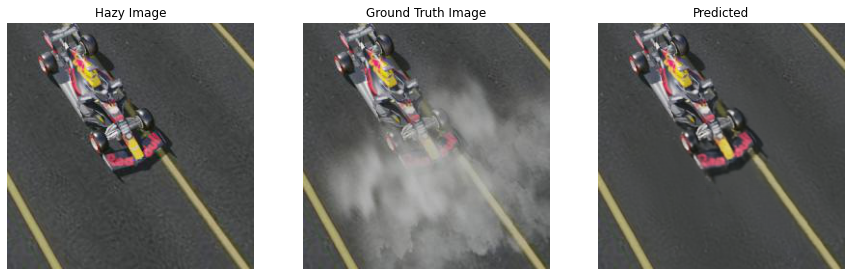

KeyboardInterrupt: ignored

In [17]:
net.to(device)
net=train(net,0.001,4)
net=train(net,0.0005,4)
net=train(net,0.0003,4)
net=train(net,0.0001,4)
net=train(net,0.00005,4)
net=train(net,0.00001,4)

In [ ]:

net.to(device)
net=train(net,0.00001,5)
torch.save(net.state_dict(), '/content/drive/MyDrive/state_dict_model_2.pt')

In [ ]:
net.to(device)
net=train(net,0.00005,2)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
net.to(device)
net=train(net,0.00001,5)
torch.save(net.state_dict(), '/content/drive/MyDrive/state_dict_model_2.pt')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
net.to(device)
net=train(net,0.000001,5)
torch.save(net.state_dict(), '/content/drive/MyDrive/state_dict_model_2.pt')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
!rm -rf  '/home/data/data/test/clear/*'
net.eval()
i=0
from torchvision.utils import save_image
import os
for im in (os.listdir('/home/data/data/test/smoke')):
  ind=im.split('.')[0]
  hzim=Image.open('/home/data/data/test/smoke/'+str(ind)+'.jpg')
  hzim=(np.asarray(hzim)/255)
  hzim=torch.from_numpy(hzim).float()
  hzim=hzim.permute(2,0,1)
  hzim=hzim.reshape((1,hzim.size()[0],hzim.size()[1],hzim.size()[2]))
  hzim=hzim.to(device)
  clim=net(hzim)
  clim=clim[0]
  save_image(clim,'/home/data/data/test/clear/'+im)

!pwd
%cd '/home/data/data/test/'
!zip submission.zip -r 'clear/' > /dev/null
!aicrowd submission create -c f1-smoke-elimination -f submission.zip

/home/data
/home/data/data/test
submission.zip ━━━━━━━━━━━━━━━━━━━━━━ 100.0% • 38.5/38.5 MB • 3.2 MB/s • 0:00:00
                                                   ╭─────────────────────────╮                                                    
                                                   │ Successfully submitted! │                                                    
                                                   ╰─────────────────────────╯                                                    
                                                         Important links                                                          
┌──────────────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│  This submission │ https://www.aicrowd.com/challenges/ai-blitz-8/problems/f1-smoke-elimination/submissions/140327              │
│                  │                                                                                 

In [ ]:
for key in state_dict.keys():
    state_dict[key] = torch.from_numpy(state_dict[key])